In [221]:
import utils as ut
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from music_dataloader import createLoaders
import numpy as np
import time

torch.manual_seed(7)

In [222]:
def preprocessing():
    
    # Check if your system supports CUDA
    use_cuda = torch.cuda.is_available()

    # Setup GPU optimization if CUDA is supported
    if use_cuda:
        computing_device = torch.device("cuda")
        extras = {"num_workers": 1, "pin_memory": True}
        print("CUDA is supported")
    else: # Otherwise, train on the CPU
        computing_device = torch.device("cpu")
        extras = False
        print("CUDA NOT supported")

    # load data
    loaders, encoder = createLoaders(extras=extras)
    dataloaders = dict(zip(['train', 'val', 'test'], loaders))
    for phase in dataloaders:
        print('%s size: %i' % (phase, len(dataloaders[phase])))
    
    return dataloaders, encoder

In [203]:
class Composer(nn.Module):
    
    def __init__(self, dim=93, hidden_dim=150):
        super(Composer, self).__init__()
        self.dim = dim
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_size=dim, hidden_size=hidden_dim,
                            batch_first=True)
        self.linear = nn.Linear(hidden_dim, dim)
        self.hidden = self._init_hidden()
        
    def _init_hidden(self):
        return [torch.zeros([1, 1, self.hidden_dim]),
                torch.zeros([1, 1, self.hidden_dim])]
    
    def forward(self, chunk):
        assert(chunk.shape[0]==1)
        # assert(chunk.shape[1]==100)
        assert(chunk.shape[2]==93)
        self.hidden = [h.detach() for h in self.hidden]
        output, self.hidden = self.lstm(chunk, self.hidden)
        opt_chunk = self.linear(output.view(chunk.shape[1], -1))
        return opt_chunk # output
    
    
class Evaluation():
    def __init__(self):
        self.loss = .0
        self.count = 0
        self.losses = []
        self.count_save = 0
        
    def __call__(self, loss, outputs):
        
        loss_ = loss.detach().numpy()
        outputs_ = outputs.detach().numpy().squeeze()
        # print(outputs_.shape)
        assert(outputs_.shape[0]==100)
        
        chunk_size = outputs_.shape[0]
        self.loss += loss_ * chunk_size
        self.count += chunk_size
        
    def avg_loss(self):
        return self.loss / self.count
        
    def save(self):
        self.count_save += 1
        self.losses.append(self.avg_loss())
        
    
def build_model(input_dim=93, learning_rate=0.1):
    
    model = Composer(dim=input_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    # optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    return model, criterion, optimizer
    
    
def train_model(model, criterion, optimizer, dataloaders, 
                num_epochs=1, start_epoch=1):
    # init timer
    since = time.time()
    
    # init evaluator
    evaluators = {'train': Evaluation(), 'val': Evaluation()}
    
    for epoch in range(start_epoch, num_epochs+1):
        print('\nEpoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)
        
        ## reset evaluate in each epoch
        for phase in evaluators:
             evaluators[phase].count_save = 0
        
        for i, (inputs, targets) in enumerate(dataloaders['train']):
            
            # clear out gradients
            model.zero_grad()
            
            # regular stuff
            outputs = model(inputs)
            # squeeze the unnecessary batchsize dim
            loss = criterion(outputs.squeeze(), targets.squeeze())
            loss.backward()
            optimizer.step()
            
            # evaluation
            evaluators['train'](loss, outputs)
            
            # validate every n chunks
            if i % 100 == 0:
                # validate first
                validate_model(model, criterion,
                               dataloaders['val'],
                               evaluators['val'])
                
                # save loss
                for key in evaluators:
                    evaluators[key].save()
                    
                print('[%i] '
                      'train-loss: %.4f '
                      'val-loss: %.4f '
                      '' % (evaluators['train'].count_save-1,
                            evaluators['train'].avg_loss(),
                            evaluators['val'].avg_loss()))
                
            # test only
            if i == 1000:
                 break
                
    time_elapsed = time.time() - since
    print('\nTraining complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    return evaluators, model
                

# could also be use to test
def validate_model(model, criterion, loader, evaluate):
    
    model.eval() # Set model to evaluate mode
    
    with torch.no_grad():
        for j, (inputs, targets) in enumerate(loader):
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets.squeeze())
            evaluate(loss, outputs)
            if j == 2:
                break # for test
            
    model.train() # Set model to training mode


In [205]:
dataloaders, encoder = preprocessing()
evaluators, model = train_model(*build_model(input_dim=encoder.length, 
                                             learning_rate=0.1), 
                                 dataloaders)

CUDA NOT supported
train size: 3799
val size: 674
test size: 540

Epoch 1/1
----------
[0] train-loss: 4.5323 val-loss: 4.5303 
[1] train-loss: 4.0834 val-loss: 4.3503 
[2] train-loss: 3.8863 val-loss: 4.2380 
[3] train-loss: 3.7267 val-loss: 4.2004 
[4] train-loss: 3.6808 val-loss: 4.1645 
[5] train-loss: 3.6710 val-loss: 4.1118 
[6] train-loss: 3.6654 val-loss: 4.0799 
[7] train-loss: 3.6220 val-loss: 4.0887 
[8] train-loss: 3.5948 val-loss: 4.0855 
[9] train-loss: 3.5628 val-loss: 4.0810 
[10] train-loss: 3.5589 val-loss: 4.0685 

Training complete in 0m 50s


In [246]:
def generate_music(model, encoder, length=100):
    
    # evaluation mode
    model.eval()
    
    # init_hidden
    # model.hidden = model._init_hidden()
    
    # init note
    init_notes = load_input_label('pa4Data/test.txt')[0][:110] #'<start>\nX:19\nT:Dusty Miller, The'
    init_seq = []
    for w in init_notes:
        init_seq.append(encoder.get_one_hot(w))
        
    init_seq = torch.tensor(init_seq, dtype=torch.float)
    init_seq = init_seq.view(1,len(init_seq),-1)
    # print(init_seq)
    
    def _get_indices(output, temperature=1):
        # print(output.squeeze().shape)
        # F.softmax(output, dim=2).detach().numpy().argsort(axis=2)
        dim = output.shape[1]
        opt_soft = F.softmax(output / temperature, 
                             dim=1).detach().numpy()
        # ind = np.argmax(opt_soft, axis=1)
        inds = []
        for opt in opt_soft:
            assert(opt.shape==(93,))
            inds.append(np.random.choice(dim, 1, p=opt).squeeze())
        # print(inds)
        return inds
    
    def _to_input(output):
        characters = []
        inputs = []
        for ind in _get_indices(output):
            character = encoder.get_character(ind)
            characters.append(character)
            inputs.append(encoder.get_one_hot(character))
        inputs = torch.tensor(inputs, dtype=torch.float)
        inputs = inputs.view(1, len(characters), -1)
        # print(characters)
        assert(inputs.shape[-1] == 93)
        return characters, inputs
    
    notes = []
    with torch.no_grad():
        outputs = model(init_seq)
        characters, inputs = _to_input(outputs)
        notes.extend(characters)
        # pick the last one
        input = inputs[:, -1, :].view(1, 1, -1)
        # print(input)
        for _ in range(length):
            output = model(input)
            # print(output.squeeze().detach().numpy())
            character, input = _to_input(output)
            notes.extend(character)
            # notes.append(encoder.get_character(_get_index(output)))
    
    return ''.join(notes)

In [248]:
generate_music(model, encoder, length=200)

'rgzG  ce/B  dn?\n 2d4r/d 4c >Au\neu\\f e:ro: bddE2BG : g/ |/|e:A| (|c| :VdeA  C|oc|: 2|/n  :C2eAsc:fd?u : en F uubc/1 A3/2(uc o 40Mt c|cBAZ ct/ lt: /orc !a ec2B>0i c8e o|c u/.2>vezac|Bc idfP Dcd r://c)doAf>32 P|id z B  ||le- c|B1)\n eAd3tg T/|/@|  (BF4dn^2e p O|!e>a0e\n3c A/\n#GalfrB/=cDf5o/ 4 /a d0i\n e >(GfoecBc c'

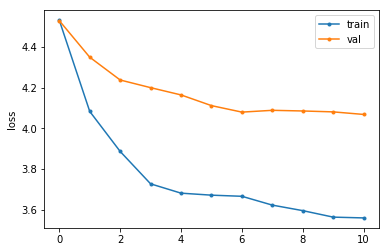

In [249]:
import matplotlib.pyplot as plt

plt.plot(evaluators['train'].losses, '.-', label='train')
plt.plot(evaluators['val'].losses, '.-', label='val')
plt.legend()
plt.ylabel('loss')
plt.show()

### for test

In [170]:
# init note
init_notes = '<start>'
init_seq = []
for w in init_notes:
    init_seq.append(encoder.get_one_hot(w))

init_seq = torch.tensor(init_seq, dtype=torch.float)
init_seq = init_seq.view(1,len(init_seq),-1)

outputs, model.hidden = model.lstm(init_seq, model.hidden)
# print(outputs)
# np.argmax(F.softmax(model.lstm(output.view(1,1,-1), model.hidden)[0].squeeze(), dim=0).detach().numpy())

print(F.softmax(outputs, dim=2).detach().numpy().argsort(axis=2))
# torch.argmax
# print(len(torch.argmax(F.softmax(outputs, dim=2).detach(), dim=2).apply_(lambda x: x**2)))
np.argmax(F.softmax(outputs, dim=2).squeeze().detach().numpy(), axis=1)

[[[76 58 45 51 83 69 52 73 89 85 31 74 88 60 80 92 42 90 63 70 68 84 35
   77 66 75 91 72 61 82  7 78 30 36 86 87 81 24 64 19 46 43 38 67 65 79
   40 34 47 71 44 12 41 57 55 22 62 37 13 25 39 32  0 10  9  1 26 56  2
   15 54 29 17  4 27 14 23 48  5 49 16  3  8 21 20  6 50 28 59 18 33 53
   11]
  [45 51 58 85 76 83 90 73 42 88 89 74 52 80 69 68 92 84 31 66 70 91 60
   30 35 72 77 63 75 36  7 78 87 61 24 86 81 82 43 46 38 19 64 34 67 40
   79 65 47 71 44 12 57 41 55 37 62 22 13 25 39 32  0 10  9  1 26 15 56
   54 29  2  4 27 14 17 48 23  5 49 16  3  8 21 20  6 50 28 59 33 18 53
   11]
  [45 76 58 85 51 83 73 80 90 92 74 69 89 42 31 52 63 60 88 35 66 77 84
   68 91 70  7 75 61 72 36 30 78 82 24 86 87 81 64 19 46 43 38 67 65 34
   79 44 40 12 71 47 57 41 55 22 62 25 37 13 39  0 32 10  9  1 15 26 56
    2 54 29  4 27 14 17 48 23  5 49 16  3  8 21  6 20 50 28 59 18 33 53
   11]
  [76 58 74 83 51 45 89 42 85 88 52 90 73 69 84 80 70 68 31 92 77 66 60
   86 30 91  7 36 63 78 61 35 75 72 81 82 8

array([11, 11, 11, 11, 11, 11, 11])

In [ ]:
lstm = nn.LSTM(93,93, batch_first=True)
hidden = (torch.zeros([1, 1, 93]),
          torch.zeros([1, 1, 93]))
criterion = nn.CrossEntropyLoss()
for i, (chunk, target) in enumerate(train_loader):

    # print('-',chunk.shape)
    output, (h,c) = lstm(chunk, hidden)
    loss = criterion(output.squeeze(), target.squeeze())
    loss.backward()
    if i == 20:
        break